In [ ]:
import os 

In [1]:
import sys
print(sys.path)

['c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\python36.zip', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\DLLs', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\lib', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36', '', 'C:\\Users\\Paul PC\\AppData\\Roaming\\Python\\Python36\\site-packages', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\lib\\site-packages', 'c:\\users\\paul pc\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Paul PC\\.ipython']


In [4]:
!mkdir data

In [52]:
import os

import re
from PIL import Image
import pandas as pd
import cv2 as cv
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class DataLoader:
    
    def __init__(self,names_path,desc_path,label_path,in_img_path,out_img_path,verbose):
        self.verbose = verbose
        self.names_path = names_path
        self.desc_path = desc_path
        self.in_img_path = in_img_path
        self.out_img_path = out_img_path
        self.label_path = label_path
        self.gtsdb = pd.read_csv(os.path.abspath(label_path), sep=";", header=None,names=
                                 ["img", "x1", "y1", "x2", "y2","id"])
        print(self.gtsdb.head())
        
    def __getitem__(self,idx):
        return {'img':self.load_image(idx),
                'label':self.gtsdb.iloc[idx]['id'],
                'name':self.gtsdb.iloc[idx]['img'],
                'x1':self.gtsdb.iloc[idx]['x1'],
               'x2':self.gtsdb.iloc[idx]['x2'],
               'y1':self.gtsdb.iloc[idx]['y1'],
                'y2':self.gtsdb.iloc[idx]['y2']}
        
    def __len__(self):
        return len(self.gtsdb)
        
    def load_image(self,idx):
        if(self.verbose):
            print("Loading image at {0}".format(self.gtsdb.iloc[idx]['img']))
        return Image.open(os.path.join(self.in_img_path,self.gtsdb.iloc[idx]['img']))
    
    def format_class_name(self,class_name):
        class_name = class_name.lower().replace(' ','-')+'\n'
        if(self.verbose):
            print(class_name)
        return class_name
    
    def dump_class_name(self,path,class_name):
        with open(os.path.abspath(path),'w') as f:
            f.write(class_name+os.linesep)
            
    def dump_classes(self):
        lines = []
        with open(os.path.abspath(self.desc_path),'r') as desc_file:
            lines = desc_file.readlines()
        if(self.verbose):
            print("".join(lines))
        pattern = re.compile('^\d{1,2}\s=\s(.*)')
        search  = lambda l : re.search(pattern,l)
        names =[match.group(1) for match in map(search,lines) if(match is not None) ]
        with open(os.path.abspath(self.names_path), 'w') as names_file:
            for n in names:
                names_file.write(self.format_class_name(n))
   
    def convert_all(self):
        cache = []
        for im in self:
            if(im['name'] not in cache):
                self.ppm2jpg(im['img'],im['name'])
                cache.append(im['name'])

    
    def ppm2jpg(self,img,img_name):
        os.makedirs(self.out_img_path,exist_ok=True)
        img.save(os.path.join(self.out_img_path,os.path.splitext(img_name)[0]+'.jpg'))
    
    
    def get_bb_coordinates(self,example):
        im_height = example['img'].height
        im_width = example['img'].width
        x_center = (example['x2']+example['x1'])/(2.0*im_width)
        y_center = (example['y2']+example['y1'])/(2.0*im_height)
        height = (example['y2']-example['y1'])/im_height
        width = (example['x2']-example['x1'])/im_width
        return{'label':example['label'],
               'x_center':x_center,
               'y_center':y_center,
               'width':width,
               'height':height}
        
    def dump_all(self):
        for img_name in self.gtsdb.img:
            if(self.verbose):
                print(img_name)
            with open(os.path.join(self.out_img_path,os.path.splitext(img_name)[0]+'.txt'),'w') as label_file:
                for index, row in self.gtsdb.loc[self.gtsdb['img'] == img_name].iterrows():
                    bb_coordinates = self.get_bb_coordinates(self[index])
                    
                    if(self.verbose):
                        print(index)
                        print(bb_coordinates)
                    sep = ' '
                    label_file.write(str(bb_coordinates['label'])+sep+str(bb_coordinates['x_center'])+sep+
                                     str(bb_coordinates['y_center'])
                                     +sep+str(bb_coordinates['width'])+sep+str(bb_coordinates['height'])+'\n')
 

                

In [67]:
def inv_conv_coordinates(x_center,y_center,rel_height,rel_width, im_height,im_width):
    width = rel_width*im_width 
    height = rel_height*im_height
    y1 = y_center*im_height - height//2
    y2 = y_center*im_height + height//2
    x1 = x_center*im_width - width//2
    x2 = x_center*im_width + width//2
    return x1,y1,x2,y2
    
    
def draw_bb(im,relative_center,relative_dimensions,im_dimensions):
    
    im = cp.copy(im)
    print(relative_center)
    print(relative_dimensions)
    print(im_dimensions)
    x_center,y_center = relative_center
    height, width = relative_dimensions
    im_height, im_width,_ = im_dimensions
    x1,y1,x2,y2=inv_conv_coordinates(x_center,y_center,height,width, im_height,im_width)
    print(x1,y1,x2,y2)
    return cv.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)),color=(255,0,0),thickness=2)

def display_image(im):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1),plt.imshow(im)
    plt.show()
    
def PIL2Np(im):
    pil_image = im.convert('RGB') 
    open_cv_image = np.array(pil_image)
    return open_cv_image[:, :, ::-1].copy()


In [4]:
dataLoader = DataLoader(verbose=False,names_path=os.path.join('data','obj.names'),desc_path=os.path.
           join('TrainIJCNN2013','ReadMe.txt'),in_img_path='TrainIJCNN2013',out_img_path= os.path.join('data','obj'),
                        label_path=os.path.join('TrainIJCNN2013','gt.txt'))

         img   x1   y1    x2   y2  id
0  00000.ppm  774  411   815  446  11
1  00001.ppm  983  388  1024  432  40
2  00001.ppm  386  494   442  552  38
3  00001.ppm  973  335  1031  390  13
4  00002.ppm  892  476  1006  592  39


In [134]:
img = dataLoader[2]

print(img)
dataLoader.ppm2jpg(img['img'],img['name'])

{'img': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1360x800 at 0x1BA03EF0E48>, 'label': 38, 'name': '00001.ppm'}


(800, 1360, 3)
(0.7952205882352941, 0.398125)
(0.09375, 0.05661764705882353)
(800, 1360, 3)
1043.5 281.5 1119.5 355.5


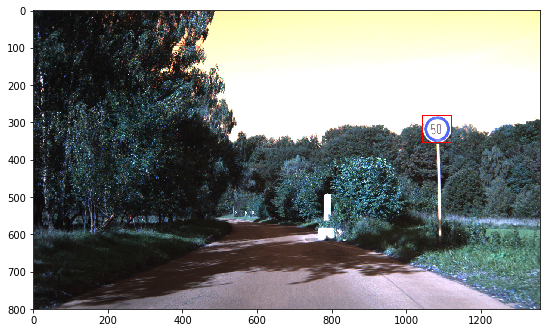

In [71]:
# Sanity check
example = dataLoader[20]

im = PIL2Np(example['img'])

print(im.shape)

bb_coordinates = dataLoader.get_bb_coordinates(example)

new_im = draw_bb(im,(bb_coordinates['x_center'],bb_coordinates['y_center']),(bb_coordinates['height'],bb_coordinates['width']),
        im.shape)
display_image(new_im)

In [135]:
dataLoader.convert_all()

In [175]:
dataLoader.dump_all()